In [1]:
%load_ext autoreload
%autoreload 2

In [104]:
import numpy as np
import torch
from torch import nn
import torch
import time
import unet

from tqdm.auto import tqdm

import swyft
import pylab as plt
import scipy.stats.distributions as dist

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

### Generative model

In [3]:
bounds = None

In [54]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, bounds_theta = None, Npix = 64, sigma = 0.1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(3., 2)], bounds = bounds_theta)
        self.bounds = bounds
        self.Npix = Npix
        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler(Npix)
        self.sigma = torch.ones(Npix, Npix)*0.1
#        self.sigma[:,:Npix//2] *= 1000

    def get_pk_fn(self, theta):
        return lambda k: 1e6*3*(k/0.5)**-theta[0]
        
    def sample_delta(self, pk_fn):
        if self.bounds is not None:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
#            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])
            return self.powersampler.sample(pk_fn)
            
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        pk_fn = graph.node("pk_fn", self.get_pk_fn, theta)
        delta = graph.node("delta", self.sample_delta, pk_fn)
        rho = graph.node("rho", lambda delta: torch.exp(delta/5), delta)
        x = graph.node("x", lambda rho: rho + torch.randn(self.Npix, self.Npix)*self.sigma, rho)
#        z = graph.node("test", lambda: lambda x: x)

/home/cweniger/.pyenv/versions/3.10.11/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


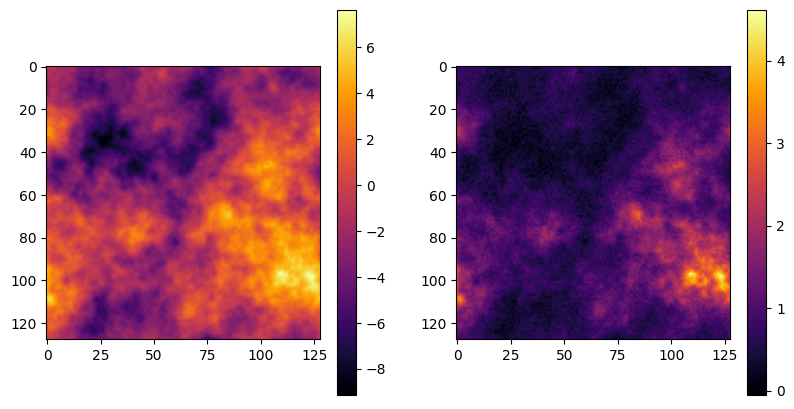

In [5]:
NPIX = 128
sim = SimulatorBlob(Npix = NPIX)
sample0 = sim.sample(conditions = dict(theta = np.array([3.8])))
plt.figure(figsize = (15, 5))
plt.subplot(131)
plt.imshow(sample0['delta'], cmap = 'inferno')
plt.colorbar()
plt.subplot(132)
plt.imshow(sample0['x'], cmap = 'inferno')
plt.colorbar()

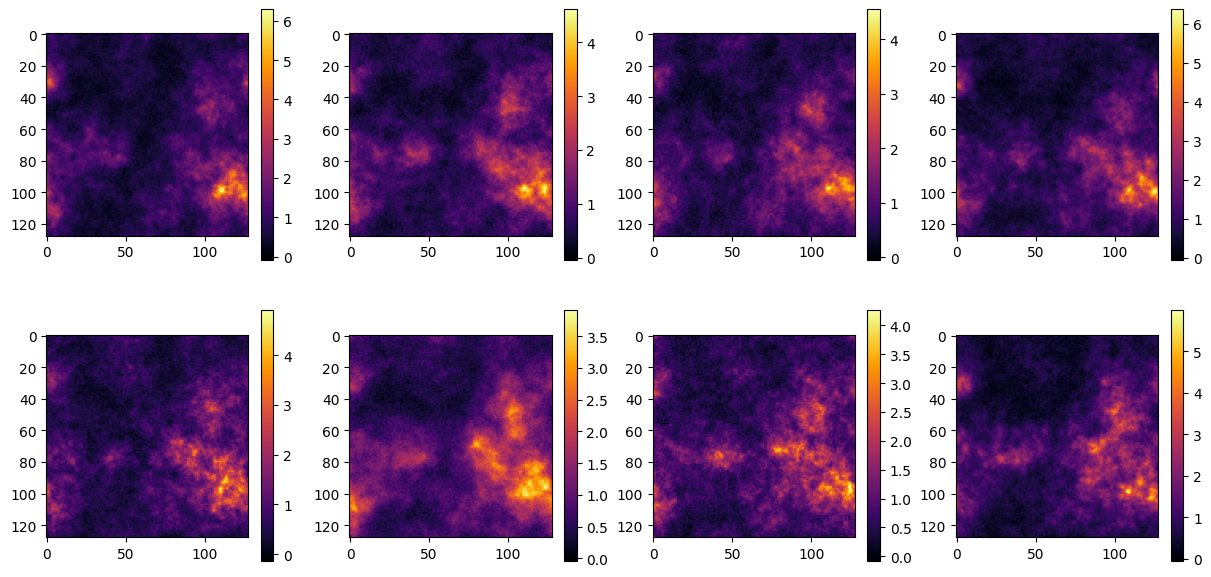

In [140]:
#NPIX = 128
sim = SimulatorBlob(Npix = NPIX, bounds = bounds)
#samples = sim.sample(8)
plt.figure(figsize = (15, 15))
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.imshow(samples[i]['x'], cmap = 'inferno')
    plt.colorbar()

### Inference network

In [160]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, N = 1024):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-4, lrs_factor=0.1, lrs_patience=3)
        self.N = N
        L = lambda x: x*0
        self.Phi = lambda x: x
        self.PhiT = lambda x: x
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", Phi = self.Phi, PhiT = self.PhiT, L = L, minstd = 1e-5, momentum=0.02)
        self.lre2 = swyft.LogRatioEstimator_1dim(2, 1, 'theta')
        self.unet = unet.UNet(1, 1, s = 4)
        self.cnn = torch.nn.Sequential(
            torch.nn.LazyConv2d(4, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2),
            torch.nn.LazyConv2d(8, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2),
            torch.nn.LazyConv2d(16, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2),
            torch.nn.LazyConv2d(32, 3), torch.nn.ReLU(), torch.nn.MaxPool2d(2),
            torch.nn.LazyConv2d(64, 3)
        )
        self.l = torch.nn.LazyLinear(2)
    
    def embed(self, x):
        x = self.unet(x.unsqueeze(1)).squeeze(1) + x
        x = x.view(-1, self.N**2)
        return x
    
    def ps_estimator(self, x):
        f = self.cnn(x.unsqueeze(1))
        f = self.l(f.flatten(start_dim=1))
        return f

    def forward(self, A, B):
        N = self.N
        if 'x' in B.keys():
            rhoA = self.embed(A['x'])
            rhoB = self.embed(B['x'])
            deltaB = B['delta'].view(-1, N**2)
            result = self.lre(rhoA, rhoB, deltaB)
        else:
            result = None
        
        f = self.ps_estimator(A['x'])
        result2 = self.lre2(f, B['theta'])

        return result2#, result

### Inference

In [161]:
#sim = SimulatorBlob(Npix = NPIX, bounds = bounds)
#samples = sim.sample(1000, exclude = ['pk_fn'])
#net.cpu(); net.float()
dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)
net = Network(N = NPIX)
trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = 1, max_epochs = 40)
trainer.fit(net, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                                                     | Params
----------------------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Gaussian_Autoregressive_X_module_based | 0     
1 | lre2 | LogRatioEstimator_1dim                                   | 17.5 K
2 | unet | UNet                                                     | 1.9 M 
3 | cnn  | Sequential                                               | 0     
4 | l    | LazyLinear                                               | 0     
----------------------------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.839     Total estimated model params size (MB)


Epoch 0:  88%|█████████████████████████████████████████████████████████████████████▋         | 15/17 [00:01<00:00, 10.25it/s, loss=0.00119, v_num=259]
Validation: 0it [00:00, ?it/s]
Epoch 1:  88%|████████████████████████████████████████████████████▉       | 15/17 [00:01<00:00, 10.49it/s, loss=0.000273, v_num=259, val_loss=0.00223]
Validation: 0it [00:00, ?it/s]
Epoch 2:  88%|████████████████████████████████████████████████████▉       | 15/17 [00:01<00:00, 10.55it/s, loss=9.38e-05, v_num=259, val_loss=0.00162]
Validation: 0it [00:00, ?it/s]
Epoch 3:  88%|███████████████████████████████████████████████████▏      | 15/17 [00:01<00:00, 10.44it/s, loss=-0.000408, v_num=259, val_loss=0.000926]
Validation: 0it [00:00, ?it/s]
Epoch 4:  88%|████████████████████████████████████████████████████       | 15/17 [00:01<00:00, 10.45it/s, loss=-0.00345, v_num=259, val_loss=0.000103]
Validation: 0it [00:00, ?it/s]
Epoch 5:  88%|████████████████████████████████████████████████████▉       | 15/17 [00:01<0

### Evaluation

In [150]:
sim = SimulatorBlob(Npix=128, bounds_theta = bounds_theta)
prior_samples = sim.sample(10000, targets = ["theta"])
s = swyft.Sample(x = sample0['x'])
results = trainer.infer(net, s, prior_samples)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9996.57it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 98.52it/s]


tensor([[3.5409, 4.0388]])


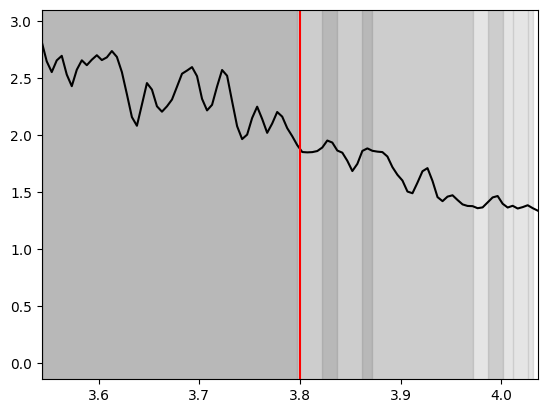

In [151]:
swyft.plot_1d(results, 'theta[0]', smooth = 1)
plt.axvline(3.8, color='r')
bounds_theta = swyft.collect_rect_bounds(results[0], 'theta', (1,), threshold = 1e-3)
print(bounds_theta)

In [162]:
GAMMA = 0.01

x = sample0['x']
y = net.cuda().double().embed(torch.tensor(x).cuda().double().unsqueeze(0))[0]
draws = []
thetas = []

for i in tqdm(range(1000)):
    s = SimulatorBlob(bounds_theta = bounds_theta, Npix = NPIX).sample()
    pk = s['pk_fn']
    theta = s['theta']
    prior = sim.powersampler.get_prior_Q_factors(pk)
    prior = (prior[0], prior[1].cuda(), prior[2])
    x0 = net.lre.get_MAP(y, prior, gamma = GAMMA)
    draw = net.lre.get_noise_samples_GEDA(1, prior, steps = 500, reset = True, gamma = GAMMA)
    draws.append(draw[0].detach().cpu())
    thetas.append(theta)


  2%|█▋                                                                                                             | 15/1000 [00:09<10:33,  1.56it/s]


KeyboardInterrupt: 

In [134]:
bounds = [(x0.view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
bounds = np.array(bounds)
thetas = np.array(thetas)

### Round 0

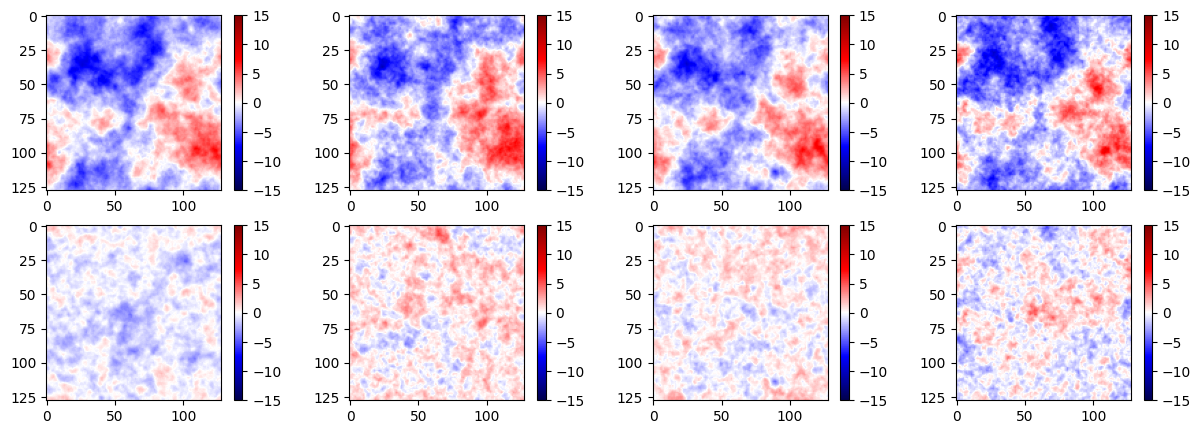

In [123]:
v = 15
plt.figure(figsize = (15, 5))
for i in range(4):
    plt.subplot(2, 4, i+1)
    if i == 0:
        plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
    else:
        plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()    
res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
for i in range(4):
    plt.subplot(2, 4, i+1+4)
    plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
    plt.colorbar()

In [158]:
sim2 = SimulatorBlob(Npix=128)
def c_sampler():
    i = np.random.randint(300)
    return dict(theta = torch.tensor(thetas[i]), delta = torch.tensor(bounds[i]))

samples = sim2.sample(1000, conditions = c_sampler,  exclude = ['pk_fn'])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2653.07it/s]
